**Prática de Segmentação de imagens**

In [2]:
# code here
import cv2
import matplotlib.pyplot as plt
import numpy as np

1) Faça a plotagem do histograma da imagem, observando o histograma, escolha um valor para definir um threshold

In [7]:
def plot_histograma(image, title):
    # Calcular o histograma da imagem
    hist, bins = np.histogram(image.flatten(), bins=256, range=[0, 256])
    
    # Plotar o histograma
    plt.figure(figsize=(10, 5))
    plt.plot(hist, color='black')
    plt.title(title)
    plt.xlabel('Valor do Pixel')
    plt.ylabel('Número de Pixels')
    plt.xlim(0, 255)
    plt.grid(True)
    plt.show()

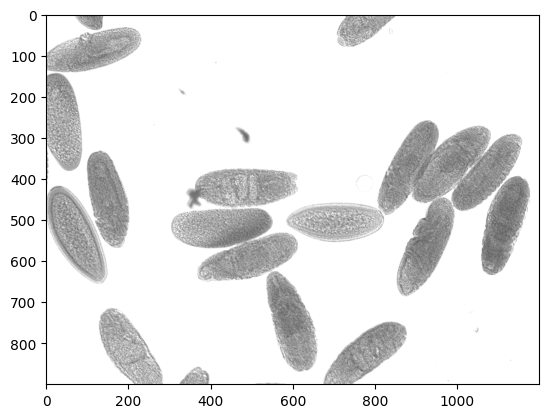

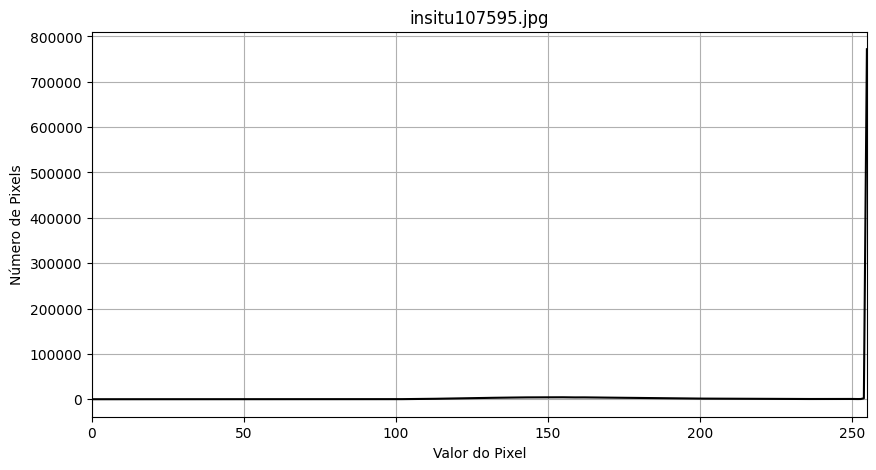

In [8]:
img1 = cv2.imread("insitu107595.jpg", cv2.IMREAD_GRAYSCALE)

plt.imshow(img1, cmap='gray', vmin=0, vmax=255)


plot_histograma(img1, "insitu107595.jpg")

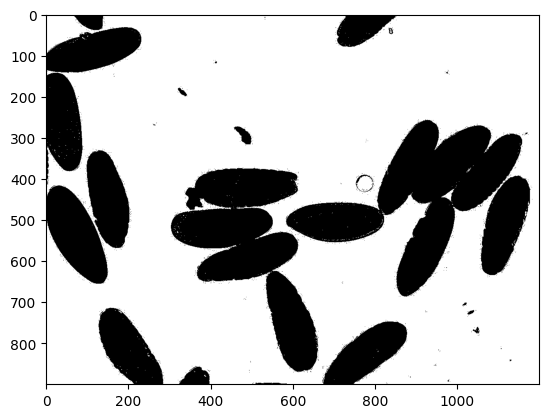

In [5]:
_, imagem_binaria = cv2.threshold(img1, 254, 1, cv2.THRESH_BINARY)

plt.imshow(imagem_binaria, cmap='gray', vmin=0, vmax=1)


2)	Segmentação utilizando a técnica de Threshold Adaptativo (implementar o algortimo). Faça a aplicação do Threshold com e sem suavização prévia

In [17]:
def treshold_adaptativo(img):
    limiar_inicial = int(np.mean(img))
    limiar_atual = limiar_inicial
    variacao_limiar = -1

    while(variacao_limiar != 0):
        grupo_1 = []
        grupo_2 = []

        for linha in img:
            for elemento in linha:
                if elemento < limiar_atual:
                    grupo_1.append(elemento)
                else:
                    grupo_2.append(elemento)

        media_grupo_1 = np.mean(grupo_1)
        media_grupo_2 = np.mean(grupo_2)

        novo_limiar = (media_grupo_1 + media_grupo_2) // 2

        variacao_limiar = limiar_atual - novo_limiar

        limiar_atual = novo_limiar

    _, imagem_binaria = cv2.threshold(img, limiar_atual, 1, cv2.THRESH_BINARY)

    return imagem_binaria

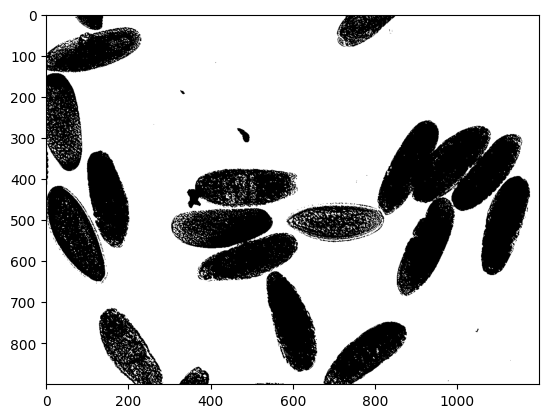

In [18]:
# SEGMENTAÇÃO SEM SUAVIZAÇÃO

img1 = cv2.imread("insitu107595.jpg", cv2.IMREAD_GRAYSCALE)

imagem_binaria = treshold_adaptativo(img1)

plt.imshow(imagem_binaria, cmap='gray', vmin=0, vmax=1)

In [19]:
# filtro gaussiano

# Função para adicionar padding
def adicionar_padding(imagem, altura_mascara, largura_mascara):
    margem_altura = altura_mascara // 2
    margem_largura = largura_mascara // 2
    imagem_padded = np.pad(imagem, ((margem_altura, margem_altura), (margem_largura, margem_largura)), mode='constant')
    return imagem_padded

# Função para aplicar a convolução com uma máscara
def aplicar_convolucao(img, mascara):
    altura_mascara, largura_mascara = mascara.shape
    imagem_padded = adicionar_padding(img, altura_mascara, largura_mascara)
    resultado = np.zeros_like(img)

    # Aplicar a convolução manualmente
    for i in range(altura_mascara // 2, imagem_padded.shape[0] - altura_mascara // 2):
        for j in range(largura_mascara // 2, imagem_padded.shape[1] - largura_mascara // 2):
            janela = imagem_padded[i - altura_mascara // 2:i + altura_mascara // 2 + 1,
                                   j - largura_mascara // 2:j + largura_mascara // 2 + 1]
            resultado[i - altura_mascara // 2, j - largura_mascara // 2] = np.sum(janela * mascara)
    
    return np.clip(resultado, 0, 255).astype(np.uint8)

img2 = cv2.imread("ben2.png", cv2.IMREAD_GRAYSCALE)

# plt.imshow(img2, cmap='gray', vmin=0, vmax=255)

def g(x,y,sigma):
    fator = (1/ (2*np.pi*(sigma**2)))
    result = fator * np.exp( -(x**2 + y**2) / (2*(sigma**2)))
    
    return result

def criar_mascara(tamanho,sigma):
    result = np.zeros((tamanho,tamanho))
    a = tamanho//2
    b = tamanho//2
    
    for x in range(-a, a):
        for y in range(-b, b):
            result[x+a+1, y+b+1] = g(x,y,sigma)
    result = result/np.sum(result[:])
    
    return result

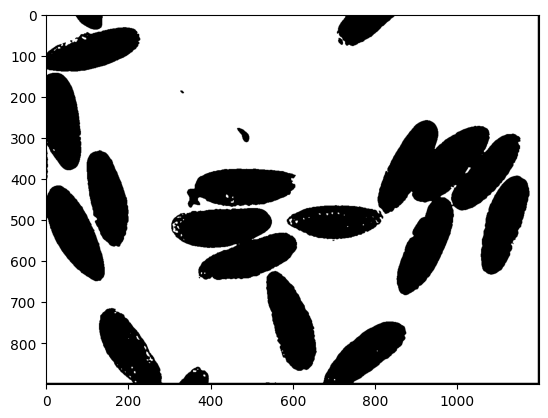

In [8]:
# SEGMENTAÇÃO COM SUAVIZAÇÃO

img1 = cv2.imread("insitu107595.jpg", cv2.IMREAD_GRAYSCALE)

sigma_9x9 = 2
tamanho_9x9 = 9
mascara_9x9 = criar_mascara(tamanho_9x9, sigma_9x9)
blur = aplicar_convolucao(img1, mascara_9x9)

imagem_binaria = treshold_adaptativo(blur)

plt.imshow(imagem_binaria, cmap='gray', vmin=0, vmax=1)

3) Segmentação utilizando a técnica de Otsu (implementar) . Faça a aplicação do Threshold com e sem suavização prévia. Mostre um gráfico com o histograma juntamente com a variância entre classes (Exemplo: https://en.wikipedia.org/wiki/File:Otsu%27s_Method_Visualization.gif)

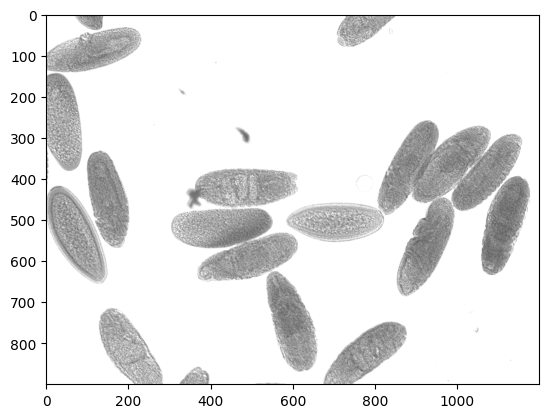

In [20]:
img1 = cv2.imread("insitu107595.jpg", cv2.IMREAD_GRAYSCALE)

plt.imshow(img1, cmap='gray', vmin=0, vmax=255)

In [21]:
# Função para calcular o threshold de Otsu manualmente
def otsu_threshold(image):
    # Calcula o histograma da imagem
    hist, _ = np.histogram(image.ravel(), bins=256, range=(0, 256))
    total_pixels = image.size
    
    # Variáveis para calcular a probabilidade acumulada e média
    sumB = 0
    wB = 0
    sum1 = np.dot(np.arange(256), hist)
    var_max = 0.0
    threshold = 0
    
    # Loop para calcular a variância entre classes para cada threshold
    for i in range(256):
        wB += hist[i]  # Peso da classe background
        if wB == 0:
            continue
        wF = total_pixels - wB  # Peso da classe foreground
        if wF == 0:
            break
        sumB += i * hist[i]
        mB = sumB / wB  # Média da classe background
        mF = (sum1 - sumB) / wF  # Média da classe foreground
        var_between = wB * wF * (mB - mF) ** 2  # Variância entre classes
        
        # Maximiza a variância entre classes
        if var_between > var_max:
            var_max = var_between
            threshold = i

    return threshold

In [11]:
# Função para aplicar o threshold manual de Otsu
def apply_otsu_manual(image):
    threshold = otsu_threshold(image)
    # Aplica o threshold para segmentar a imagem
    _, imagem_binaria = cv2.threshold(image, threshold, 1, cv2.THRESH_BINARY)
    return imagem_binaria, threshold

In [12]:
# Função para calcular a variância entre classes
def calc_variancia_entre_classes(hist, total_pixels):
    sumB, wB = 0, 0
    sum1 = np.dot(np.arange(256), hist)
    var_between_classes = np.zeros(256)
    for i in range(256):
        wB += hist[i]
        if wB == 0:
            continue
        wF = total_pixels - wB
        if wF == 0:
            break
        sumB += i * hist[i]
        mB = sumB / wB
        mF = (sum1 - sumB) / wF
        var_between_classes[i] = wB * wF * (mB - mF) ** 2
    return var_between_classes

# Função para plotar o histograma e a variância entre classes
def plot_histograma_variancia(image, title):
    # Calcula o histograma
    hist = cv2.calcHist([image], [0], None, [256], [0, 256]).ravel()
    total_pixels = image.shape[0] * image.shape[1]

    # Calcula a variância entre classes
    variancia_entre_classes = calc_variancia_entre_classes(hist, total_pixels)

    # Calcula o threshold de Otsu manualmente
    otsu_thresh = otsu_threshold(image)

    # Plot do histograma e da variância entre classes
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Intensidade')
    ax1.set_ylabel('Frequência', color=color)
    ax1.plot(hist, color=color, label='Histograma')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Variância Entre Classes', color=color)
    ax2.plot(variancia_entre_classes, color=color, label='Variância')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title(f'Histograma e Variância Entre Classes - {title}')
    plt.axvline(x=otsu_thresh, color='green', linestyle='--', label=f'Threshold Otsu ({otsu_thresh})')
    fig.tight_layout()
    plt.show()

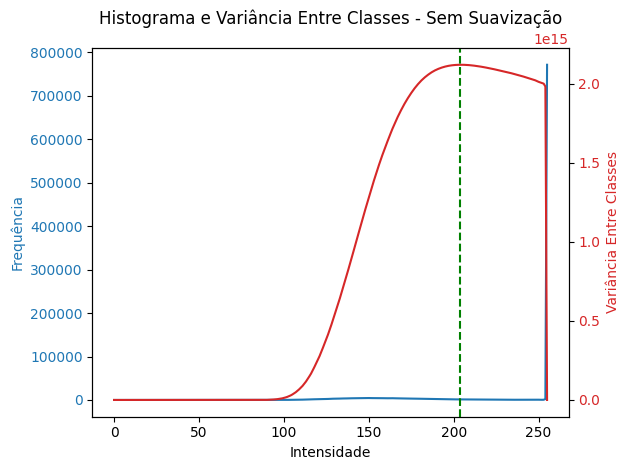

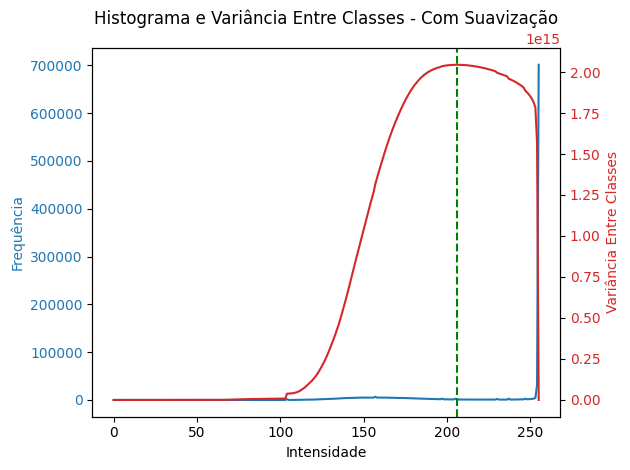

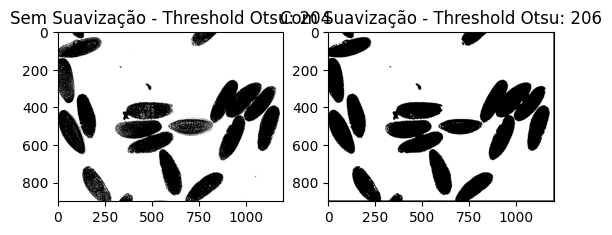

In [13]:
image = cv2.imread('insitu107595.jpg', cv2.IMREAD_GRAYSCALE)

# Segmentação sem suavização
segmented_image, threshold = apply_otsu_manual(image)
plot_histograma_variancia(image, 'Sem Suavização')

# Aplicando suavização com filtro gaussiano
sigma_9x9 = 2
tamanho_9x9 = 9
mascara_9x9 = criar_mascara(tamanho_9x9, sigma_9x9)
blurred_image = aplicar_convolucao(image, mascara_9x9)

# Segmentação com suavização
segmented_image_blur, threshold_blur = apply_otsu_manual(blurred_image)
plot_histograma_variancia(blurred_image, 'Com Suavização')

# Exibe as imagens segmentadas
plt.subplot(1, 2, 1)
plt.imshow(segmented_image, cmap='gray')
plt.title(f'Sem Suavização - Threshold Otsu: {threshold}')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image_blur, cmap='gray')
plt.title(f'Com Suavização - Threshold Otsu: {threshold_blur}')
plt.show()

## 4)	Aplique o Otsu para a imagem HE.jpg, madrill.tiff e  Lenna.jpg (use antes a conversão da imagem para tons de cinza)


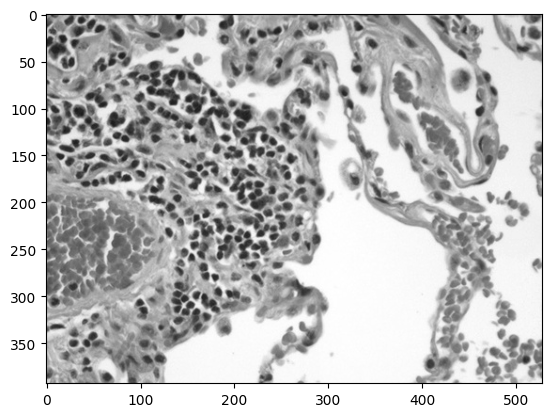

In [18]:
img1 = cv2.imread("HE.jpg", cv2.IMREAD_GRAYSCALE)

plt.imshow(img1, cmap='gray', vmin=0, vmax=255)

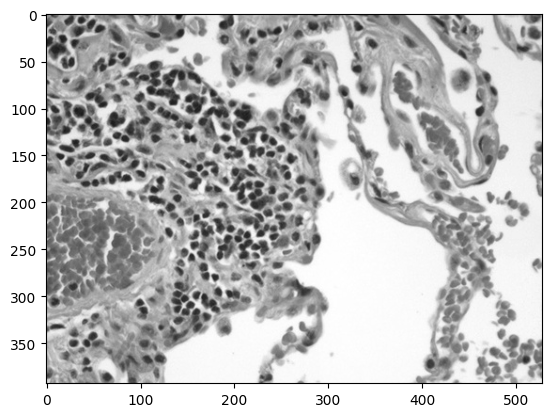

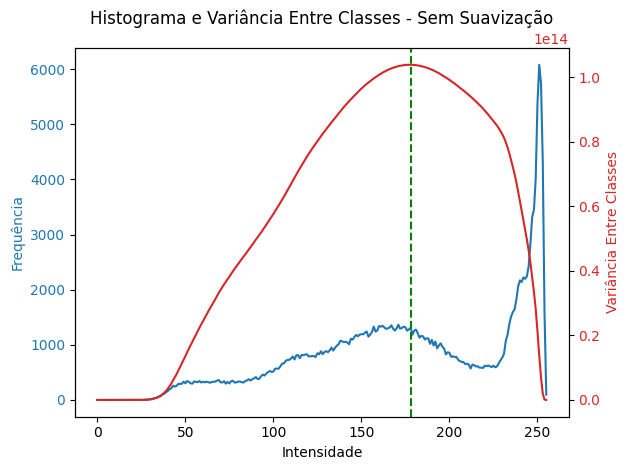

Text(0.5, 1.0, 'Sem Suavização - Threshold Otsu: 178')

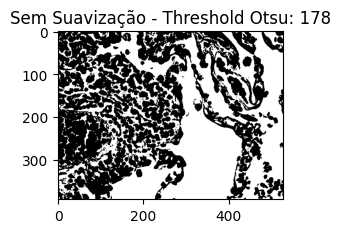

In [9]:
img1 = cv2.imread("HE.jpg", cv2.IMREAD_GRAYSCALE)

plt.imshow(img1, cmap='gray', vmin=0, vmax=255)


# Segmentação sem suavização
segmented_image, threshold = apply_otsu_manual(img1)
plot_histograma_variancia(img1, 'Sem Suavização')

# Exibe as imagens segmentadas
plt.subplot(1, 2, 1)
plt.imshow(segmented_image, cmap='gray')
plt.title(f'Sem Suavização - Threshold Otsu: {threshold}')

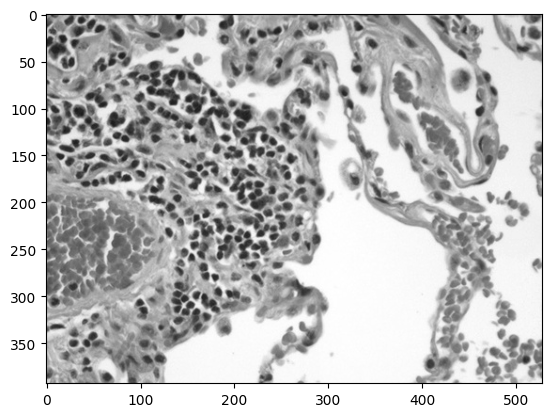

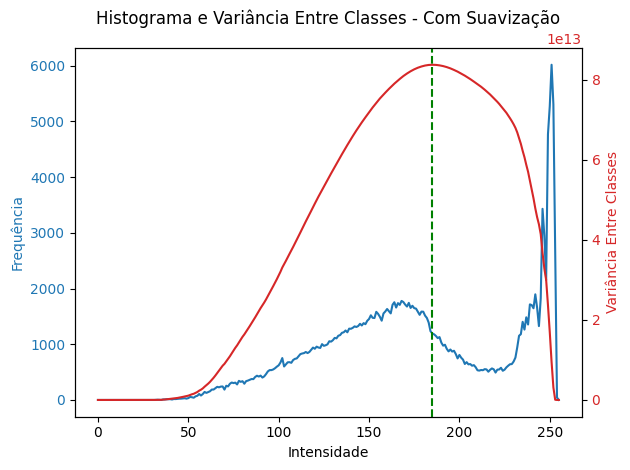

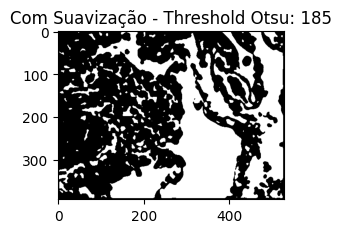

In [14]:
img1 = cv2.imread("HE.jpg", cv2.IMREAD_GRAYSCALE)

plt.imshow(img1, cmap='gray', vmin=0, vmax=255)

# Aplicando suavização com filtro gaussiano
sigma_9x9 = 2
tamanho_9x9 = 9
mascara_9x9 = criar_mascara(tamanho_9x9, sigma_9x9)
blurred_image = aplicar_convolucao(img1, mascara_9x9)

# Segmentação com suavização
segmented_image_blur, threshold_blur = apply_otsu_manual(blurred_image)
plot_histograma_variancia(blurred_image, 'Com Suavização')


plt.subplot(1, 2, 2)
plt.imshow(segmented_image_blur, cmap='gray')
plt.title(f'Com Suavização - Threshold Otsu: {threshold_blur}')
plt.show()

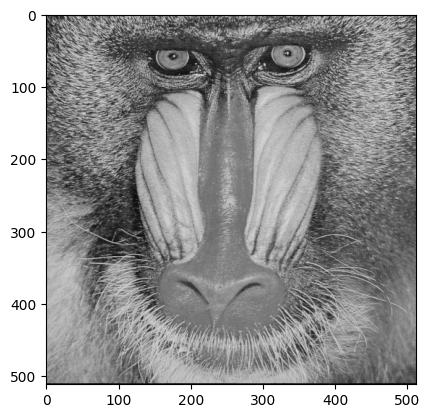

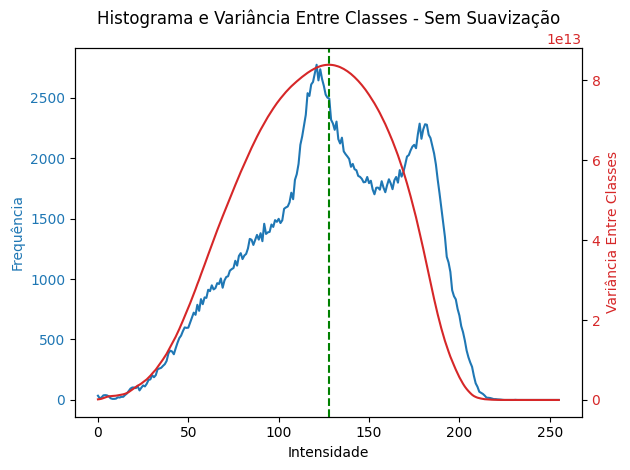

Text(0.5, 1.0, 'Sem Suavização - Threshold Otsu: 128')

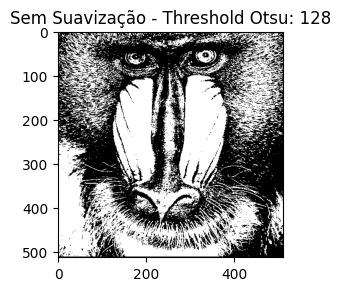

In [11]:
img1 = cv2.imread("madrill.tiff", cv2.IMREAD_GRAYSCALE)

plt.imshow(img1, cmap='gray', vmin=0, vmax=255)

# Segmentação sem suavização
segmented_image, threshold = apply_otsu_manual(img1)
plot_histograma_variancia(img1, 'Sem Suavização')

# Exibe as imagens segmentadas
plt.subplot(1, 2, 1)
plt.imshow(segmented_image, cmap='gray')
plt.title(f'Sem Suavização - Threshold Otsu: {threshold}')

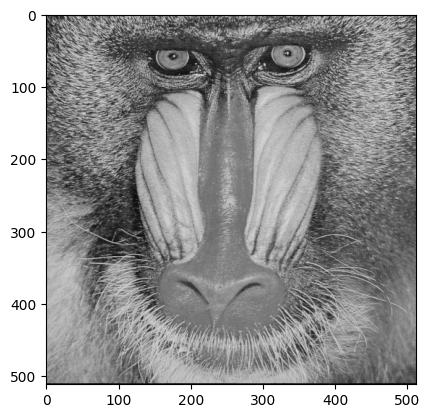

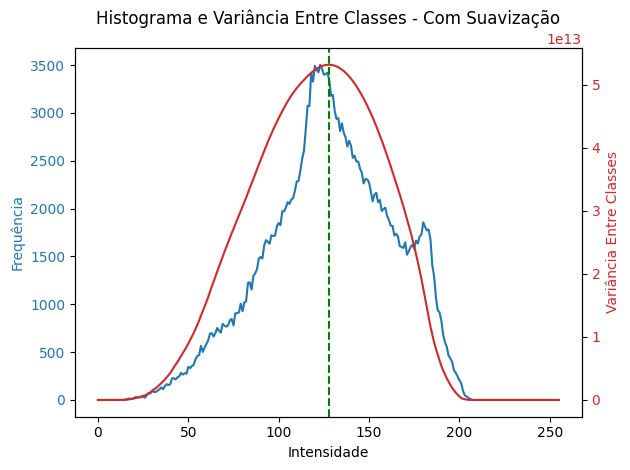

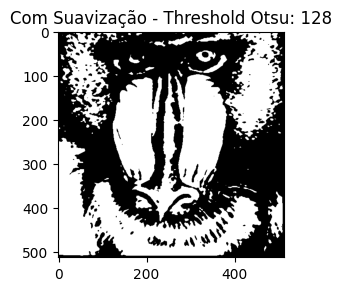

In [15]:
img1 = cv2.imread("madrill.tiff", cv2.IMREAD_GRAYSCALE)

plt.imshow(img1, cmap='gray', vmin=0, vmax=255)

# Aplicando suavização com filtro gaussiano
sigma_9x9 = 2
tamanho_9x9 = 9
mascara_9x9 = criar_mascara(tamanho_9x9, sigma_9x9)
blurred_image = aplicar_convolucao(img1, mascara_9x9)

# Segmentação com suavização
segmented_image_blur, threshold_blur = apply_otsu_manual(blurred_image)
plot_histograma_variancia(blurred_image, 'Com Suavização')


plt.subplot(1, 2, 2)
plt.imshow(segmented_image_blur, cmap='gray')
plt.title(f'Com Suavização - Threshold Otsu: {threshold_blur}')
plt.show()

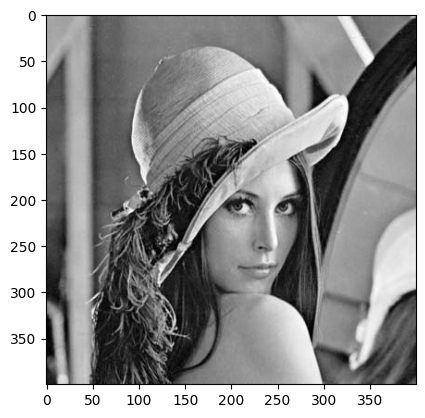

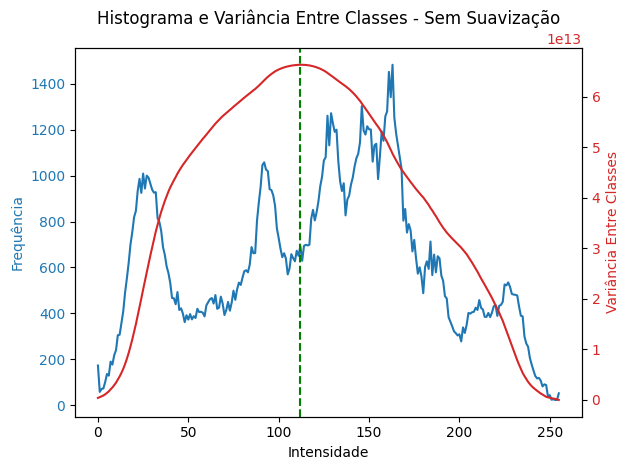

Text(0.5, 1.0, 'Sem Suavização - Threshold Otsu: 112')

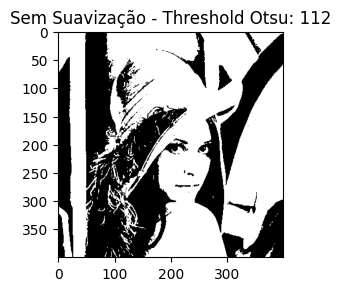

In [13]:
img1 = cv2.imread("Lenna.jpg", cv2.IMREAD_GRAYSCALE)

plt.imshow(img1, cmap='gray', vmin=0, vmax=255)

# Segmentação sem suavização
segmented_image, threshold = apply_otsu_manual(img1)
plot_histograma_variancia(img1, 'Sem Suavização')

# Exibe as imagens segmentadas
plt.subplot(1, 2, 1)
plt.imshow(segmented_image, cmap='gray')
plt.title(f'Sem Suavização - Threshold Otsu: {threshold}')

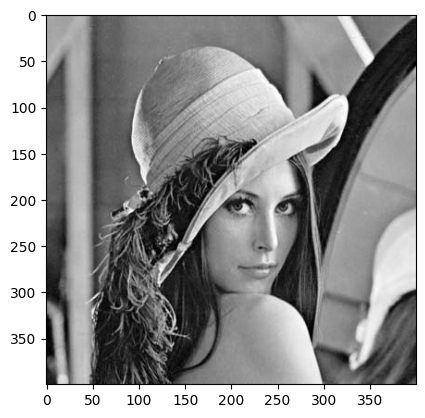

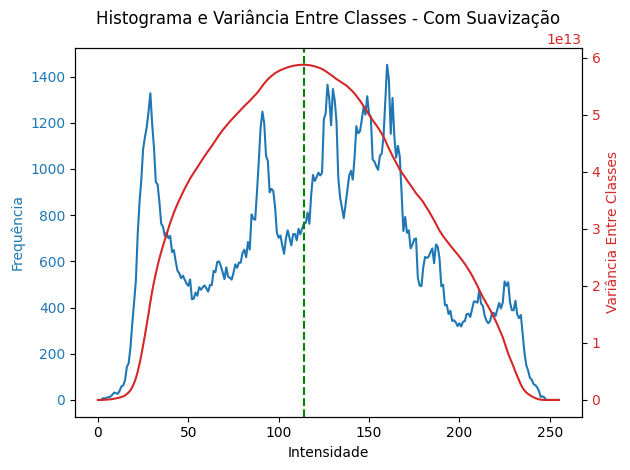

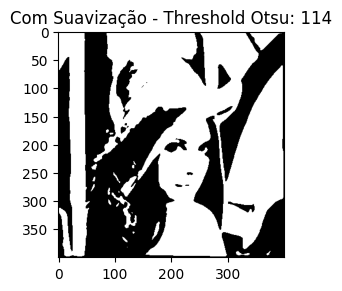

In [16]:
img1 = cv2.imread("Lenna.jpg", cv2.IMREAD_GRAYSCALE)

plt.imshow(img1, cmap='gray', vmin=0, vmax=255)

# Aplicando suavização com filtro gaussiano
sigma_9x9 = 2
tamanho_9x9 = 9
mascara_9x9 = criar_mascara(tamanho_9x9, sigma_9x9)
blurred_image = aplicar_convolucao(img1, mascara_9x9)

# Segmentação com suavização
segmented_image_blur, threshold_blur = apply_otsu_manual(blurred_image)
plot_histograma_variancia(blurred_image, 'Com Suavização')


plt.subplot(1, 2, 2)
plt.imshow(segmented_image_blur, cmap='gray')
plt.title(f'Com Suavização - Threshold Otsu: {threshold_blur}')
plt.show()